In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

以下のセルでEKF_Simulation_AllData.csvにカラム名を付与してください

In [2]:
column_names = [
    'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
    'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
    'u1_s', 'u2_s',  # s_uHistory
    'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
    'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
    'u1_l', 'u2_l'  # l_uHistory
]
df = pd.read_csv("data\EKF_Simulation_AllData.csv", names=column_names, header=None)

<>:9: SyntaxWarning: invalid escape sequence '\E'
<>:9: SyntaxWarning: invalid escape sequence '\E'
C:\Users\shump\AppData\Local\Temp\ipykernel_69940\2194141981.py:9: SyntaxWarning: invalid escape sequence '\E'
  df = pd.read_csv("data\EKF_Simulation_AllData.csv", names=column_names, header=None)


In [3]:
df.to_csv("data\EKF_Simulation_AllData.csv",index=False)

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\shump\AppData\Local\Temp\ipykernel_69940\2266658697.py:1: SyntaxWarning: invalid escape sequence '\E'
  df.to_csv("data\EKF_Simulation_AllData.csv",index=False)


次に「use_makecop.m」を実行してcopを計算してください
次にdata\EKF_Simulation_AllData_with_COP.csvを使用してcomのデータを取得します

In [4]:
df = pd.read_csv("data\EKF_Simulation_AllData_with_COP.csv")

system_params = {
    'm1': 25.00,   # Mass of the first segment (leg)
    'm2': 50.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.85,    # Length of the second segment (trunk)
    'com1': 0.45,  # Distance to CoM of the first segment
    'com2': 0.42,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Function to calculate CoM
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # Convert to radians
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # Calculate CoM positions
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    # Ensure it returns a Pandas Series with correct length
    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'],row['q2_s_true'], system_params), axis=1)
df[['com_x_l', 'com_z_l']] = df.apply(lambda row: calculate_com(row['q1_l_true'],row['q2_l_true'], system_params), axis=1)


<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\shump\AppData\Local\Temp\ipykernel_69940\3446441057.py:1: SyntaxWarning: invalid escape sequence '\E'
  df = pd.read_csv("data\EKF_Simulation_AllData_with_COP.csv")


(-40.0, 40.0)

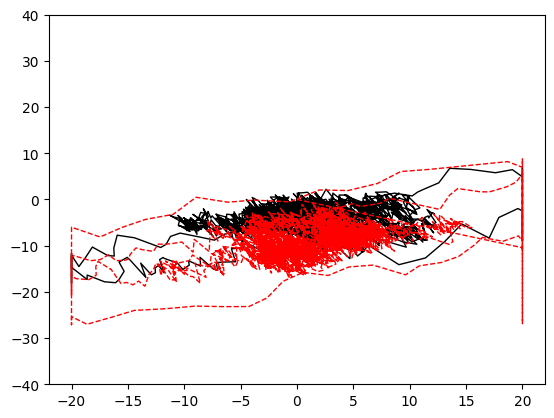

In [5]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)


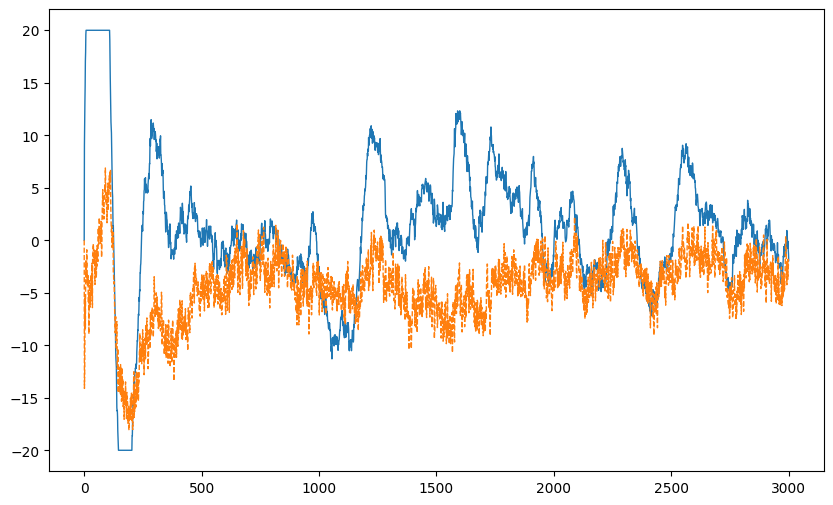

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['u1_s'], label='u1_s', linewidth=1)
plt.plot(df.index, df['u2_s'], label='u2_s', linewidth=1, linestyle='--')


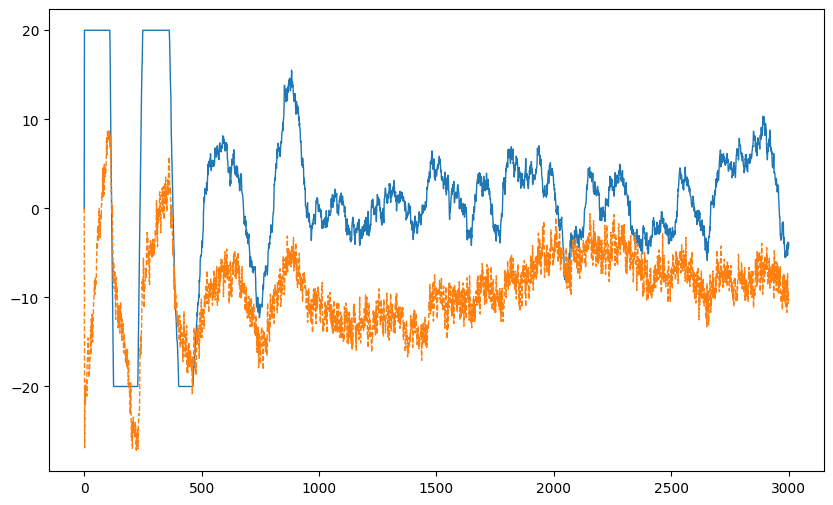

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['u1_l'], label='u1_l', linewidth=1)
plt.plot(df.index, df['u2_l'], label='u2_l', linewidth=1, linestyle='--')


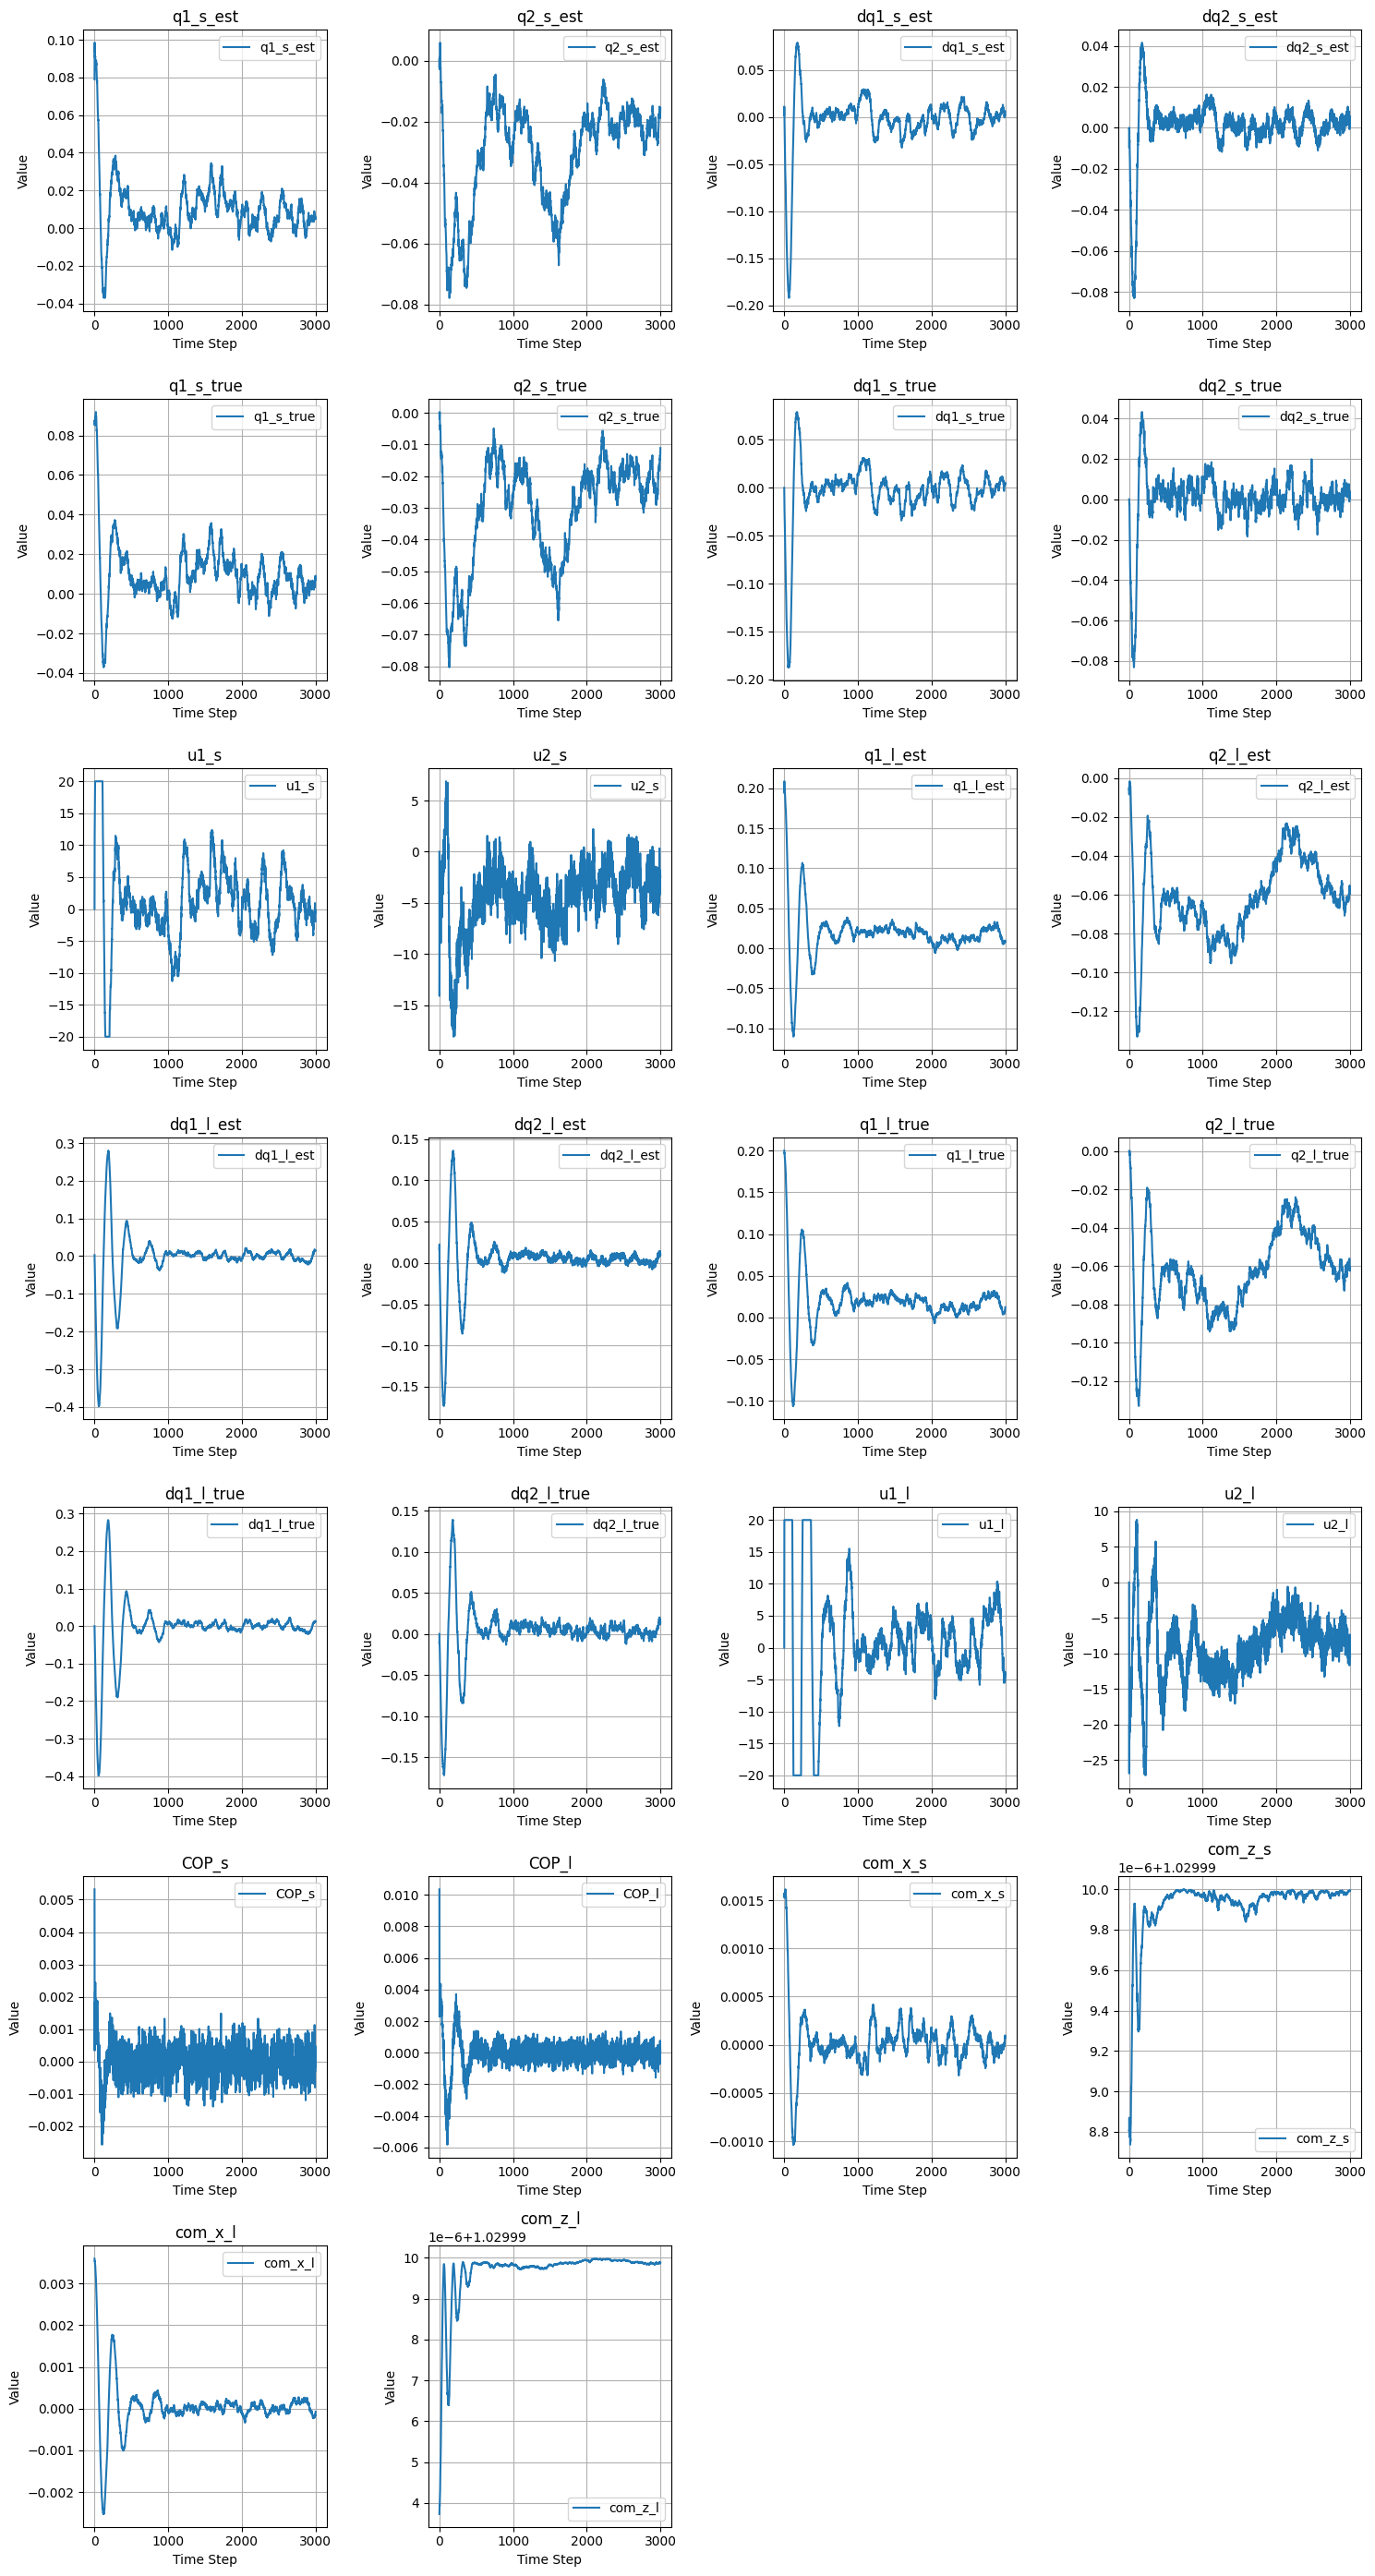

In [8]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()

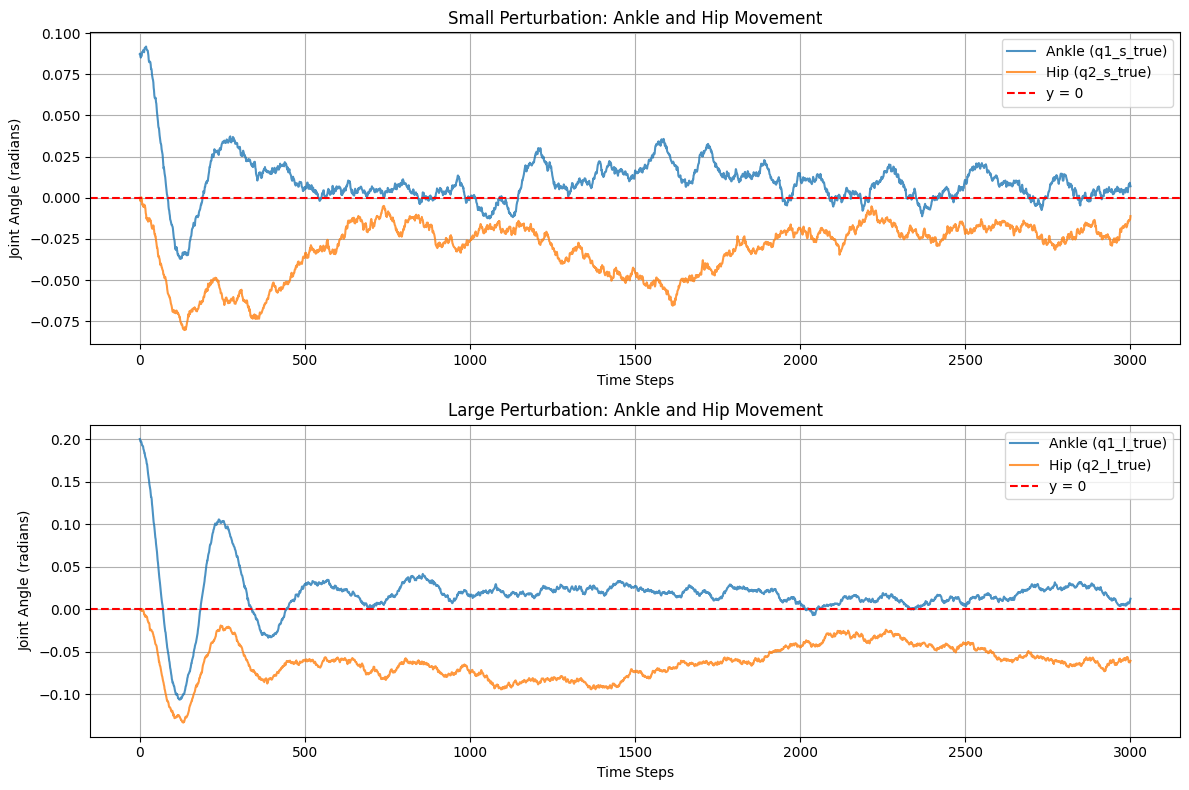

In [9]:
plt.figure(figsize=(12, 8))

# Small 
plt.subplot(2, 1, 1)
plt.plot(df['q1_s_true'], label='Ankle (q1_s_true)', alpha=0.8)
plt.plot(df['q2_s_true'], label='Hip (q2_s_true)', alpha=0.8)
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
plt.title('Small Perturbation: Ankle and Hip Movement')
plt.xlabel('Time Steps')
plt.ylabel('Joint Angle (radians)')
plt.legend()
plt.grid()

# Large
plt.subplot(2, 1, 2)
plt.plot(df['q1_l_true'], label='Ankle (q1_l_true)', alpha=0.8)
plt.plot(df['q2_l_true'], label='Hip (q2_l_true)', alpha=0.8)
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
plt.title('Large Perturbation: Ankle and Hip Movement')
plt.xlabel('Time Steps')
plt.ylabel('Joint Angle (radians)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

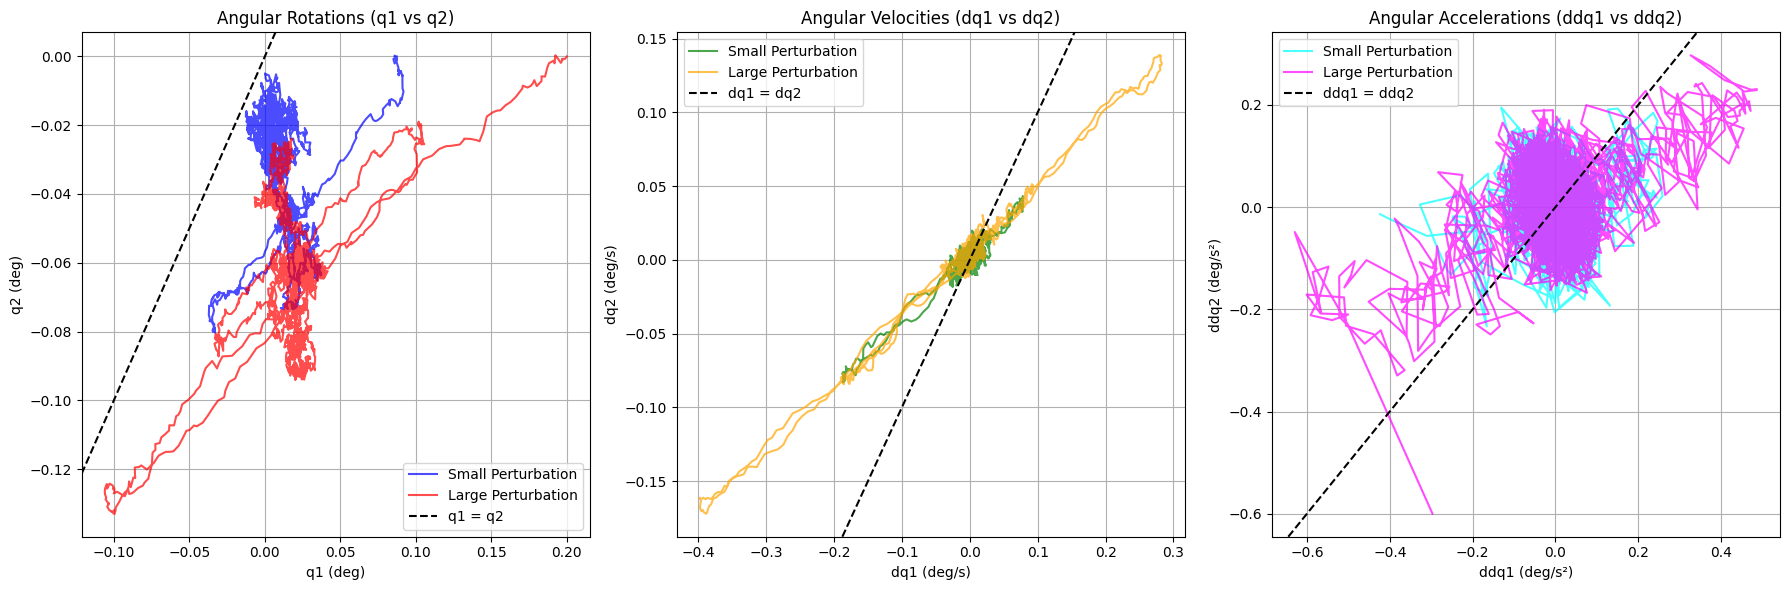

In [10]:
import numpy as np

# Calculate angular velocities (dq/dt) and accelerations (d²q/dt²) for both small and large perturbations
time_step = 0.02  # Assuming a 50 Hz sampling rate (1 / 50 s per step)

# Small perturbation
df['ddq1_s_true'] = np.gradient(df['dq1_s_true'], time_step)
df['ddq2_s_true'] = np.gradient(df['dq2_s_true'], time_step)

# Large perturbation
df['ddq1_l_true'] = np.gradient(df['dq1_l_true'], time_step)
df['ddq2_l_true'] = np.gradient(df['dq2_l_true'], time_step)

# Plotting coordination of ankle and hip oscillations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left panel: Angular rotations (q1 vs q2)
axes[0].plot(df['q1_s_true'], df['q2_s_true'], color='blue', alpha=0.7, label='Small Perturbation')
axes[0].plot(df['q1_l_true'], df['q2_l_true'], color='red', alpha=0.7, label='Large Perturbation')
axes[0].axline((0, 0), slope=1, color='black', linestyle='--', label='q1 = q2')
axes[0].set_title('Angular Rotations (q1 vs q2)')
axes[0].set_xlabel('q1 (deg)')
axes[0].set_ylabel('q2 (deg)')
axes[0].legend()
axes[0].grid()

# Central panel: Angular velocities (dq1 vs dq2)
axes[1].plot(df['dq1_s_true'], df['dq2_s_true'], color='green', alpha=0.7, label='Small Perturbation')
axes[1].plot(df['dq1_l_true'], df['dq2_l_true'], color='orange', alpha=0.7, label='Large Perturbation')
axes[1].axline((0, 0), slope=1, color='black', linestyle='--', label='dq1 = dq2')
axes[1].set_title('Angular Velocities (dq1 vs dq2)')
axes[1].set_xlabel('dq1 (deg/s)')
axes[1].set_ylabel('dq2 (deg/s)')
axes[1].legend()
axes[1].grid()

# Right panel: Angular accelerations (ddq1 vs ddq2)
axes[2].plot(df['ddq1_s_true'], df['ddq2_s_true'], color='cyan', alpha=0.7, label='Small Perturbation')
axes[2].plot(df['ddq1_l_true'], df['ddq2_l_true'], color='magenta', alpha=0.7, label='Large Perturbation')
axes[2].axline((0, 0), slope=1, color='black', linestyle='--', label='ddq1 = ddq2')
axes[2].set_title('Angular Accelerations (ddq1 vs ddq2)')
axes[2].set_xlabel('ddq1 (deg/s²)')
axes[2].set_ylabel('ddq2 (deg/s²)')
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()
